# Import modules + define routines & EPICS channels

In [213]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [214]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        #Position = BS_file[channel_laser_pitch][:][reprate_FEL]
        Palm = BS_file[channel_palm_analysis][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped, Palm

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [215]:
# only through raw and JF

channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_waveplate= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
channel_laser_yaw= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


In [36]:
# #For BS local

# channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_Izero = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
# channel_Izero2 = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
# channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
# channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
# channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
# channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
# #channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
# channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
# channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
# channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
# channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
# channel_waveplate= "SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
# channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

# #Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
# channel_position = "SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
# channel_position = "SLAAR11-LMOT-M451:ENC_1_BS/data"
# channel_energy = "SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
# channel_laser_yaw= "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
# channel_laser_pitch= "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
# channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


# Scan name

In [1]:
 scan_name ="CytC_Fe3_timescan_5uJ_288nm_7160eV_007"
#scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_004"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

# Load one step and filter some data from I0

In [2]:
 f = "CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0016.BSREAD.h5"
#f = "CytC_Fe3_timescan_5uJ_288nm_7122eV_004_step0005.BSREAD.h5"
filename = DIR + f

(signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(filename)

Izero_pump_original = Izero_pump_loop.copy()
#Izero_pump_loop = [x for x in Izero_pump_loop if (np.abs(x) > 1000)]
print (np.median(Izero_pump_loop)-1.25*(np.std(Izero_pump_loop)))
conditionPumpMax = Izero_pump_loop < np.median(Izero_pump_loop)+1.2*(np.std(Izero_pump_loop))
conditionPumpMin = Izero_pump_loop > np.median(Izero_pump_loop)-1.2*(np.std(Izero_pump_loop))

conditionUnPumpMax = Izero_unpump_loop < np.median(Izero_unpump_loop)+1.2*(np.std(Izero_unpump_loop))
conditionUnPumpMin = Izero_unpump_loop > np.median(Izero_unpump_loop)-1.2*(np.std(Izero_unpump_loop))

conditionGeneral = Izero_pump_loop > 1000
conditionGeneral2 = Izero_unpump_loop > 1000

Izero_pump_loop = Izero_pump_loop[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

Izero_pump_loop = np.asarray(Izero_pump_loop)
Izero_pump_original = np.asarray(Izero_pump_original)

NameError: name 'LoadData_knife_edge' is not defined

<IPython.core.display.Javascript object>


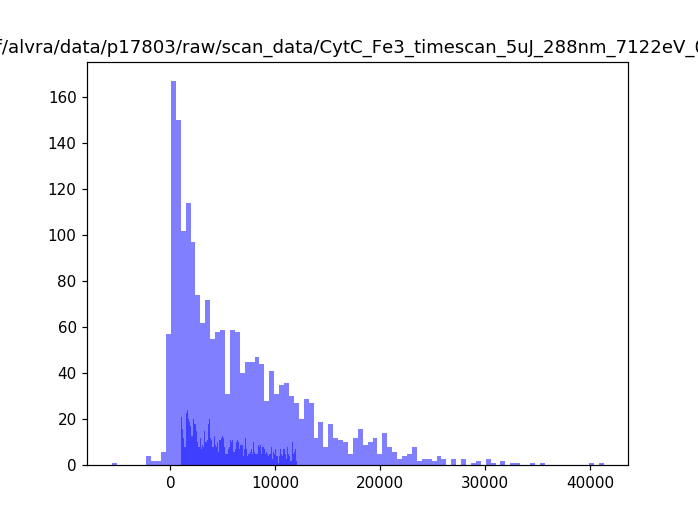

In [131]:
num_bins = 100
plt.figure()
plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
plt.hist(Izero_pump_original, num_bins, facecolor='blue', alpha=0.5)
plt.title(DIR)


plt.show()

1338 2000


<IPython.core.display.Javascript object>


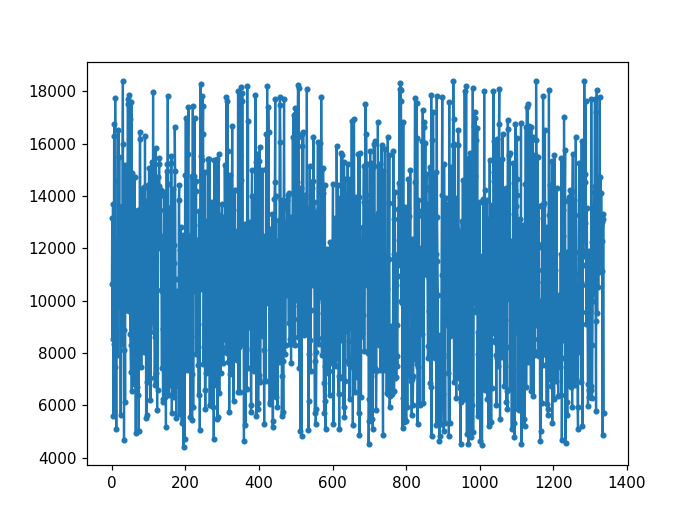

In [232]:
print (Izero_pump_loop.size, Izero_pump_original.size)
plt.figure()

#plt.plot(Izero_pump_original, label="original",marker='.')
plt.plot(Izero_pump_loop, label="Izero_pump",marker='.')

# Analyse full run

In [267]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.8T
-rw-r--r--.  1 root p17803  36G Jan 25 12:53 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803  23M Jan 25 12:54 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 12:56 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 25 12:56 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803  22M Jan 25 12:57 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 12:58 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 25 12:59 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803  23M Jan 25 13:00 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 13:01 CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0002.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 25 13

ra-c-002.psi.ch
There are 150 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/


In [268]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
Signal_diff = []
err_signal_pump = []
err_signal_unpump = []
err_signal_diff = []

SignalT_pump = []
SignalT_unpump = []
err_signalT_pump = []

Izero_pump = []
Izero_unpump = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

Palm_fs = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=5:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        
        threshold_pump = Izero_pump_loop > 1000
        threshold_unpump = Izero_unpump_loop > 1000 
        condition_pump = Izero_pump_loop > np.median(Izero_pump_loop)-1.2*(np.std(Izero_pump_loop))
        condition_unpump = Izero_unpump_loop > np.median(Izero_unpump_loop)-1.2*(np.std(Izero_unpump_loop))

        signal_pump_loop = signal_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_pump_loop = Izero_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_unpump_loop = signal_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_unpump_loop = Izero_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        signal_unpump_loop_norm = signal_unpump_loop / Izero_unpump_loop
        signal_diff_loop = signal_unpump_loop / Izero_unpump_loop
        
        Signal_pump.append(signal_pump_loop_norm.mean())
        Signal_unpump.append(signal_unpump_loop_norm.mean())
        Signal_diff.append(signal_diff_loop.mean())
        
        
        #Signal_pump.append(np.mean(signal_pump_loop))
        #Signal_unpump.append(signal_unpump_loop.mean())
        #err_signal_pump.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        #err_signal_unpump.append(signal_unpump_loop.std()/np.sqrt(signal_unpump_loop.size))
        
        #signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        
        err_signal_pump.append(signal_pump_loop_norm.std()/np.sqrt(signal_pump_loop_norm.size))
        err_signal_unpump.append(signal_unpump_loop_norm.std()/np.sqrt(signal_unpump_loop_norm.size))
        err_signal_diff.append(signal_diff_loop.std()/np.sqrt(signal_diff_loop.size))
        
        #Izero_pump.append(Izero_pump_loop.mean())
        #Izero_unpump.append(Izero_unpump_loop.mean())
        #err_Izero_pump.append(Izero_pump_loop.std()/np.sqrt(Izero_pump_loop.size))
        #err_Izero_unpump.append(Izero_unpump_loop.std()/np.sqrt(Izero_unpump_loop.size))
        
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT_pump.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        Palm_fs.append(np.mean(palm_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size,np.mean(position_loop))
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
Signal_diff = np.asarray(Signal_diff)

err_signal_pump = np.asarray(err_signal_pump)
err_signal_unpump = np.asarray(err_signal_unpump)
err_signal_diff = np.asarray(err_signal_diff)

err_signal_pump_relative = np.asarray(err_signal_pump)/Signal_pump
err_signal_unpump_relative = np.asarray(err_signal_unpump)/Signal_unpump

SignalT_pump = np.asarray(SignalT_pump)
SignalT_unpump = np.asarray(SignalT_unpump)
err_signalT_pump = np.asarray(err_signalT_pump)

Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
Palm_fs =np.asarray(Palm_fs)
Delay_ps = (Position_mm - 150.365)*2/(3e8*1e3*1e-12) # change to right t0 !
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_scan_info.json
Processing 50 files
step 1 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0000.BSREAD.h5
1849 1849 149.6309995682304
step 2 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0001.BSREAD.h5
1875 1875 149.78099956761602
step 3 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0002.BSREAD.h5
1905 1905 149.9309990170368
step 4 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0003.BSREAD.h5
1865 1865 150.08100031633924
step 5 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_

1947 1947 153.38099805296636
step 50 of 50 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_5uJ_288nm_7160eV_007/CytC_Fe3_timescan_5uJ_288nm_7160eV_007_step0049.BSREAD.h5
1947 1947 154.1310002997504
Job done!


<IPython.core.display.Javascript object>


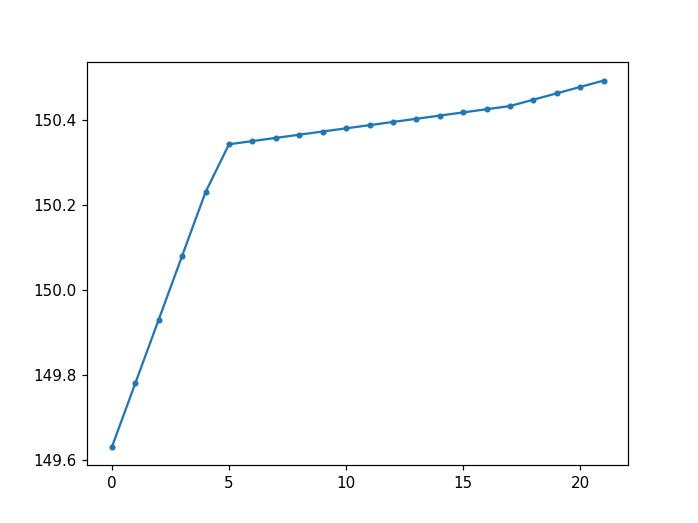

-155.81018063518079


array([149.63099957, 149.78099957, 149.93099902, 150.08100032,
       150.23100177, 150.34349982, 150.35100224, 150.35849946,
       150.36600228, 150.3735016 , 150.38100032, 150.38849839,
       150.39600101, 150.40350013, 150.4109998 , 150.41850146,
       150.42599849, 150.4335011 , 150.44849869, 150.46349878,
       150.47849922, 150.49350101])

In [235]:
plt.figure()
plt.plot(Position_mm, label="FEL+Laser",marker='.')
print(np.mean(Palm_fs))
Position_mm

1.3992588332498002
(1818,)


<IPython.core.display.Javascript object>


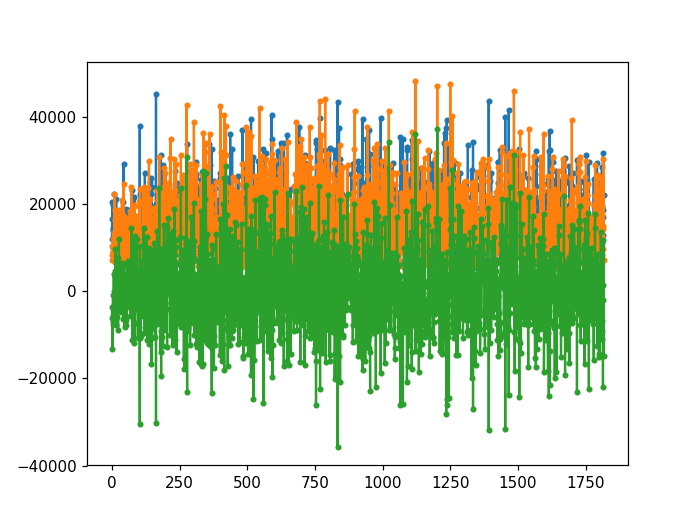

-389.9566926989719


In [236]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

<IPython.core.display.Javascript object>


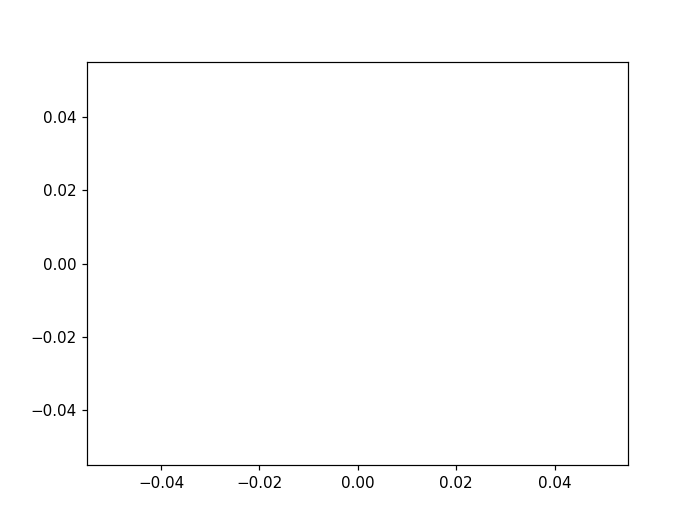

In [237]:
plt.figure()

plt.plot(Izero_pump, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump, label="FEL+Laser",marker='.')

In [269]:
Signal_pump_norm = Signal_pump #/ Izero_pump
Signal_unpump_norm = Signal_unpump #/ Izero_unpump

SignalT_pump_norm = SignalT_pump #/ Izero_pump
SignalT_unpump_norm = SignalT_unpump #/ Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_pump_norm = err_signal_pump #/ Izero_pump
err_signal_unpump_norm = err_signal_unpump #/ Izero_unpump

#err_signal_pump_relative_norm = err_signal_pump_relative / Izero_pump
#err_signal_unpump_relative_norm = err_signal_unpump_relative / Izero_unpump

#err_signalT_norm = err_signalT_pump / Izero_pump

In [84]:
# Optional to run --> it returns the maximum value of the trace
#m=max(Signal_pump_norm-Signal_unpump_norm)
#print(m)
#[i for i, j in enumerate(Signal_pump_norm-Signal_unpump_norm) if j==m] # returns the location in x axis indexes of the max
#print(Energy_eV[15])
#print(Position_mm)

# Plot Energy Scans

<IPython.core.display.Javascript object>


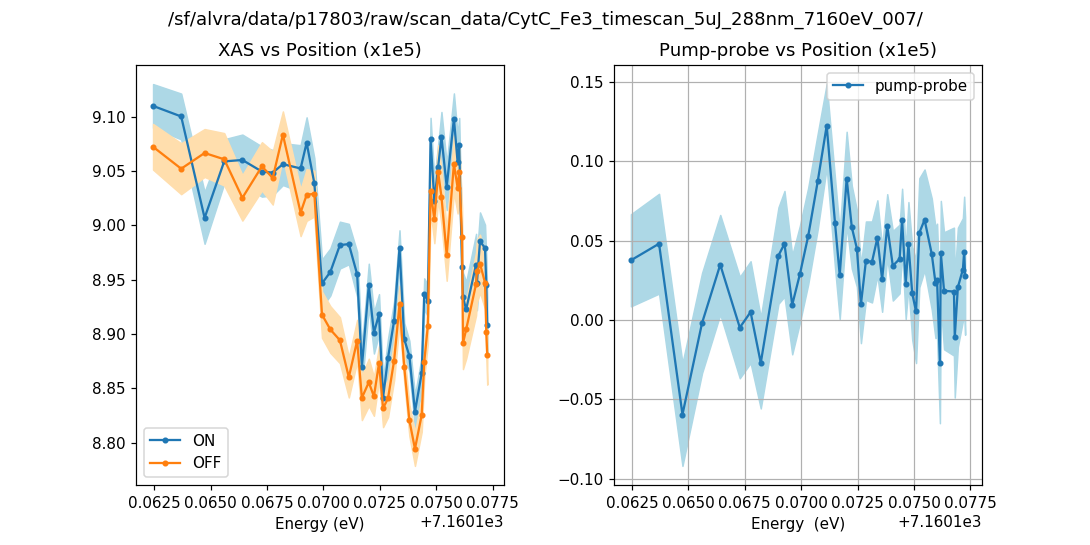

In [259]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

#low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - err_signal_pump_relative_norm
#high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + err_signal_unpump_relative_norm

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")



#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

#plt.savefig('Timescan_7_diode')

# Plot Time Scans

<IPython.core.display.Javascript object>


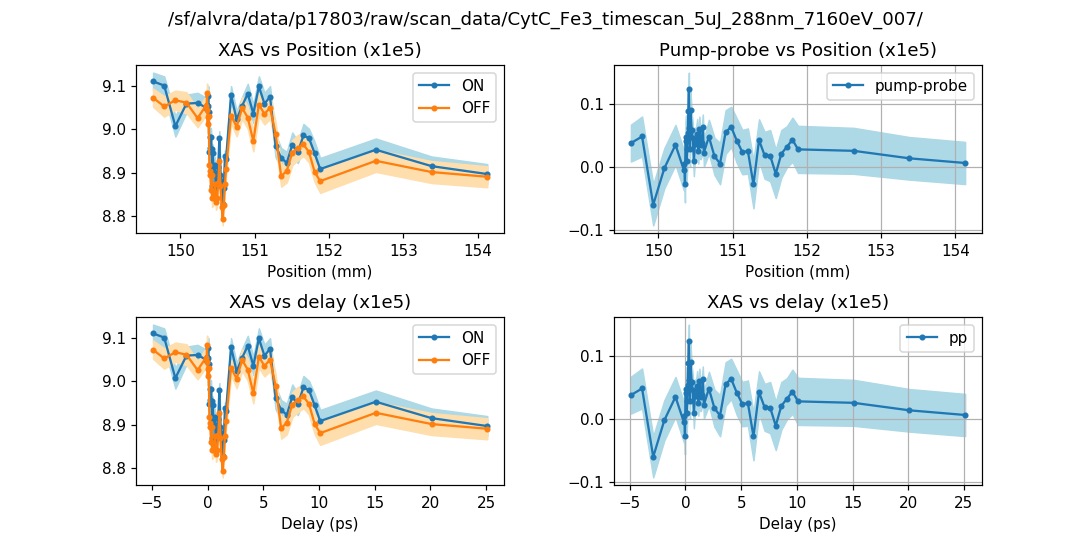

In [270]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

plt.subplot(2,2,1)
plt.plot(Position_mm, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Position_mm, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Position_mm, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Position_mm, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Position (mm)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,2)
plt.plot(Position_mm, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Position_mm, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")

plt.subplot(2,2,3)
plt.plot(Delay_ps, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Delay_ps, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,4)
plt.plot(Delay_ps, scale*(Signal_pump_norm-Signal_unpump_norm), label="pp",marker='.')
plt.fill_between(Delay_ps, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')


#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show()

# save the pp sig and its xaxis into a variable name after the scan name. 
# This is convenient to compare different scans together, see cell below.
x = scan_name + "_DIFF"
t = scan_name + "_DELAY"
vars()[x] = (Signal_pump_norm-Signal_unpump_norm)
vars()[t] = Delay_ps

#plt.savefig('Timescan_7_diode')


In [145]:
# Now fit with error funciton (defined above)
Signal_norm = Signal_pump_norm-Signal_unpump_norm
parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 150.39, 0.05]) # [baseline, step amplitude, center, FWHM]

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = 150.388 mm
Width = 0.001 mm


<IPython.core.display.Javascript object>


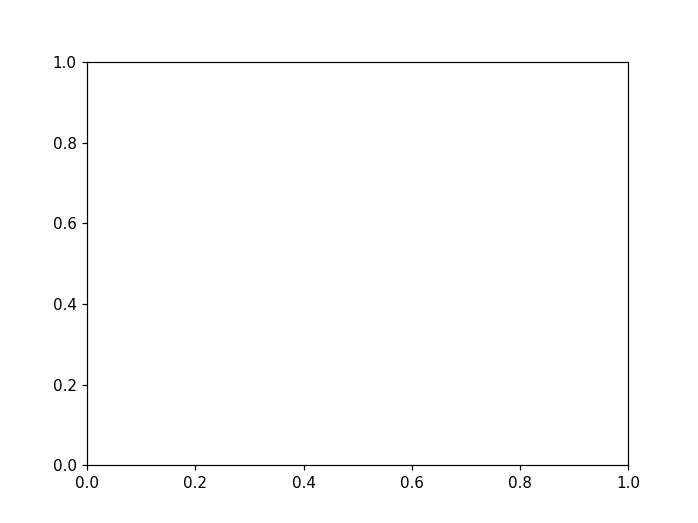

ValueError: x and y must have same first dimension, but have shapes (21,) and (49,)

In [228]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="scan_006",marker='.')
plt.plot(Position_mm, errfunc(Position_mm,*parameters))

#low_err= Signal_norm - err_signal_norm
#high_err= Signal_norm + err_signal_norm
#plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(parameters[3], 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')

# Compare runs

<IPython.core.display.Javascript object>


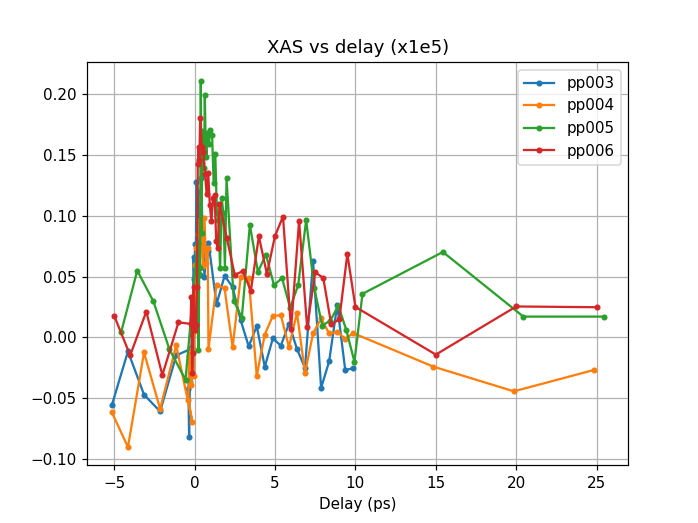

In [154]:
# you have to run the analysis once and the data will be saved in variables scan_name_DELAY and scan_name_DIFF

xaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DELAY
yaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DIFF

xaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DELAY
yaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DIFF

xaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DELAY
yaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DIFF

xaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DELAY
yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF

xaxis2SORTED = sorted(xaxis2)
sortindices2=np.argsort(xaxis2)
yaxis2original=yaxis2
yaxis2=yaxis2[sortindices2]
#yaxisMODEL = biexp(x,-0.05, 0.1, 0, 0.5, 1, 2., 1, 10.)

plt.figure()
plt.plot(xaxis1, scale*yaxis1, label="pp003",marker='.')
plt.plot(xaxis2, scale*yaxis2, label="pp004",marker='.')
plt.plot(xaxis3, scale*yaxis3, label="pp005",marker='.')
plt.plot(xaxis4, scale*yaxis4, label="pp006",marker='.')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")
plt.show()

Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003
Position t0 = 0.065 ps
Width = 0.148 ps
a1 = 0.771
t1 = 1.475 ps
a2 = 0.315
t2 = 27.718 ps
Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_004
Position t0 = 0.38 ps
Width = 0.227 ps
a1 = 5.089
t1 = 0.16 ps
a2 = 0.192
t2 = 11.211 ps
Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_005
Position t0 = 0.342 ps
Width = 0.003 ps
a1 = 1.408
t1 = 2.035 ps
a2 = 0.827
t2 = 2.035 ps


<IPython.core.display.Javascript object>


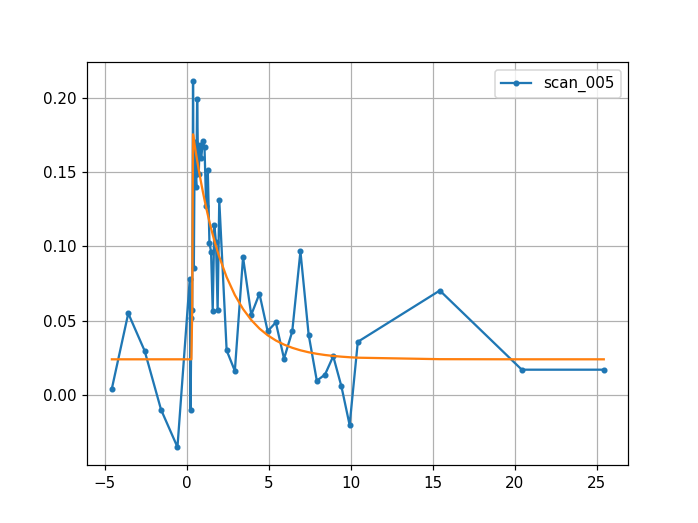

<IPython.core.display.Javascript object>


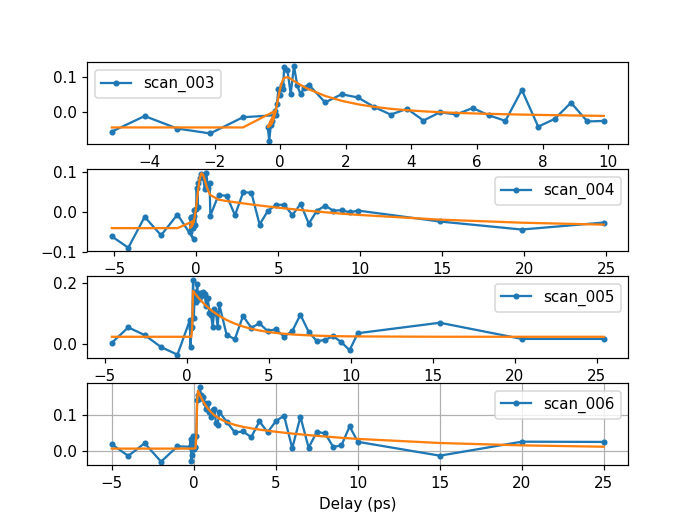

In [169]:
# Fit of the time traces
parameters1,extras = curve_fit(biexp, xaxis1, scale*yaxis1, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters2,extras = curve_fit(biexp, xaxis2, scale*yaxis2, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters3,extras = curve_fit(biexp, xaxis3, scale*yaxis3, p0 = [-0.0, 0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters4,extras = curve_fit(biexp, xaxis4, scale*yaxis4, p0 = [-0.0, 0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]


print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003")
print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters1[4],3)))
print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters1[6],3)))
print("t2 =",np.abs(np.round(parameters1[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_004")
print("Position t0 =",np.abs(np.round(parameters2[2],3)),"ps")
print("Width =",np.abs(np.round(parameters2[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters2[4],3)))
print("t1 =",np.abs(np.round(parameters2[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters2[6],3)))
print("t2 =",np.abs(np.round(parameters2[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_005")
print("Position t0 =",np.abs(np.round(parameters3[2],3)),"ps")
print("Width =",np.abs(np.round(parameters3[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters3[4],3)))
print("t1 =",np.abs(np.round(parameters3[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters3[6],3)))
print("t2 =",np.abs(np.round(parameters3[7],3)),"ps")

plt.figure()
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")
plt.grid()


plt.figure()
plt.subplot(4,1,1)
plt.plot(xaxis1, scale*yaxis1, label="scan_003",marker='.')
plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7]))
plt.legend(loc="best")

plt.subplot(4,1,2)
plt.plot(xaxis2, scale*yaxis2, label="scan_004",marker='.')
plt.plot(xaxis2, biexp(xaxis2,parameters2[0],parameters2[1],parameters2[2],parameters2[3],parameters2[4],\
                       parameters2[5],parameters2[6],parameters2[7]))
plt.legend(loc="best")

plt.subplot(4,1,3)
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")


plt.subplot(4,1,4)
plt.plot(xaxis4, scale*yaxis4, label="scan_006",marker='.')
plt.plot(xaxis4, biexp(xaxis4,parameters4[0],parameters4[1],parameters4[2],parameters4[3],parameters4[4],\
                       parameters4[5],parameters4[6],parameters4[7]))
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
plt.show()


# Other plots.

#plt.plot(xaxis1 - parameters1[2], biexp(xaxis1 - parameters1[2],parameters1[0],parameters1[1],\
#                 parameters1[2],parameters1[3],parameters1[4],parameters1[5],parameters1[6],parameters1[7]))
#plt.plot(xaxis2 - parameters2[2], biexp(xaxis2 - parameters2[2],parameters2[0],parameters2[1],parameters2[2],\
#                 parameters2[3],parameters2[4],parameters2[5],parameters2[6],parameters2[7]))



#plt.plot(xaxis1 - parameters1[2], yaxis1, label="scan_003",marker='.')
#plt.plot(xaxis2 - parameters2[2], yaxis2, label="scan_004",marker='.')


# More stuff

In [18]:
myList = np.concatenate((np.arange(7100,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [560]:
time_zero = 150.188         #this is in mm from the delay scans

desidered_delays = [-10,-1,1]  
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")


T_1 = np.arange(149.4372,150.1872


mtime = np.concatenate((np.arange(149.4372,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [561]:
print(time_zero)

150.295


In [ ]:
desidered_delays = [-10,-1,1]  


In [85]:
Position_mm

delay_ps = (Position_mm - 150.188)*2/(3e8*1e3*1e-12)
print(delay_ps)

[-5.00533552 -4.00533186 -3.00532519 -2.00533486 -1.00534287 -0.24999255
 -0.20332353 -0.15667619 -0.10999984 -0.06332083 -0.01666048  0.0299942
  0.07664888  0.12331189  0.17000857  0.21667292  0.25000578  0.35001538
  0.44999765  0.55001325  0.65001152  0.75000445  0.85001405  0.95001498
  1.00133936  1.50135569  2.00135236  2.50133269  3.00132902  3.50134502
  4.00130935  4.50133368  5.00133201  5.50134601  6.00132801  6.50133234
  7.00134667  7.50135134  8.00131634  8.50131533  9.00130167  9.50133066
 10.00130766]


In [234]:
t0_mm = 150.347
delaylist=np.concatenate((np.arange(-5.,-1.+1.,1.), np.arange(-0.25,0.3+0.05,0.05), \
                          np.arange(0.35,1.5+0.1,0.1),np.arange(2.,10.+0.5,0.5),[15.,20.,25.]))
position_list = delaylist*(3e8*1e3*1e-12)/2 + t0_mm
print(position_list)
print(delaylist)
len(delaylist)

[149.597  149.747  149.897  150.047  150.197  150.3095 150.317  150.3245
 150.332  150.3395 150.347  150.3545 150.362  150.3695 150.377  150.3845
 150.392  150.3995 150.4145 150.4295 150.4445 150.4595 150.4745 150.4895
 150.5045 150.5195 150.5345 150.5495 150.5645 150.5795 150.647  150.722
 150.797  150.872  150.947  151.022  151.097  151.172  151.247  151.322
 151.397  151.472  151.547  151.622  151.697  151.772  151.847  152.597
 153.347  154.097 ]
[-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00 -2.50000000e-01 -2.00000000e-01 -1.50000000e-01
 -1.00000000e-01 -5.00000000e-02 -5.55111512e-17  5.00000000e-02
  1.00000000e-01  1.50000000e-01  2.00000000e-01  2.50000000e-01
  3.00000000e-01  3.50000000e-01  4.50000000e-01  5.50000000e-01
  6.50000000e-01  7.50000000e-01  8.50000000e-01  9.50000000e-01
  1.05000000e+00  1.15000000e+00  1.25000000e+00  1.35000000e+00
  1.45000000e+00  1.55000000e+00  2.00000000e+00  2.50000000e+00
  3.00000000e+00  3.50000

50

In [ ]:
mytime = np.concatenate((np.arange(149.4372,150.188,0.15), np.arange(150.1505,150.2255,0.007), np.arange(150.2255,150.3382,0.015), np.arange(150.3382,151.6895,0.0
   ...: 75)))